In [3]:
from typing import Any, Dict, List, Tuple
from joblib import Parallel, delayed

from simulation.outpatient import OPSimulation

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

sns.set_style("whitegrid")

In [4]:
class SimulationWrapper:
    """
    A wrapper class for managing simulations using the OPSimulation class.
    
    This class provides functionality to run simulations either in parallel 
    or serially, and ensures proper pickling by managing the state of the
    `op_sim` object.
    """
    def __init__(self) -> None:
        """
        Initializes the SimulationWrapper with an OPSimulation instance.
        
        Attributes:
            op_sim (OPSimulation): The simulation object initialised with
                                   default SQL queries, site, and TFC values.
        """
        self.op_sim = OPSimulation(path_to_sql_queries="example_sql", site='mph', tfc=999)

    def __getstate__(self) -> Dict[str, Any]:
        """
        Customises the pickling behavior to exclude the engine from the 
        op_data attribute of op_sim.
        
        Returns:
            Dict[str, Any]: The state dictionary of the object with 
                            modifications for pickling.
        """
        state = self.__dict__.copy()
        state["op_sim"].op_data.__dict__.pop("engine", None)
        return state

    def __setstate__(self, state: Dict[str, Any]) -> None:
        """
        Restores the state of the object during unpickling.
        
        Args:
            state (Dict[str, Any]): The state dictionary to restore.
        """
        self.__dict__.update(state)

    def parallel_run(self, num_cores: int = -1, num_runs: int = 1) -> List[Tuple[Any, Any, Any]]:
        """
        Runs the simulation in parallel using the specified number of cores and runs.
        
        Args:
            num_cores (int): The number of cores to use for parallel execution. 
                             Defaults to -1 (all available cores).
            num_runs (int): The number of simulation runs. Defaults to 1.
        
        Returns:
            List[Tuple[Any, Any, Any]]: A list of results from each simulation run.
        """
        results = Parallel(n_jobs=num_cores)(
            delayed(self.serial_run)(i) for i in range(num_runs)
        )
        return results

    def serial_run(self, run_id: int = 0) -> Tuple[Any, Any, Any]:
        """
        Runs a single simulation serially.

        Args:
            run_id (int): The ID of the run (used for tracking). Defaults to 0.

        Returns:
            Tuple[Any, Any, Any]: A tuple containing the seed, the simulation
                                  instance, and the operational department.
        """
        seed, sim, opdept = self.op_sim.parameterise_simulation()
        sim.run_simulation()
        return seed, sim, opdept


In [5]:
sim_wrapper = SimulationWrapper()
seed, sim, dept = sim_wrapper.serial_run()

0 Reached
15 Reached
30 Reached
45 Reached
60 Reached
75 Reached
90 Reached
105 Reached
120 Reached
135 Reached
150 Reached
165 Reached
180 Reached
195 Reached
210 Reached
225 Reached
240 Reached
255 Reached
270 Reached
285 Reached
300 Reached
315 Reached
330 Reached
345 Reached
360 Reached


In [6]:
# The metrics can be found within the simulation:

metrics = sim.graph.nodes["Simulate"]["capacity"].metrics.metrics
metrics.keys()

dict_keys(['maximum_wait_time', 'wait_list_length', 'num_patients_seen', 'num_dnas', 'num_cancellations', 'num_discharged', 'median_wait_times_by_priority', 'max_wait_times_by_priority'])

In [25]:
def plot_linegraph(data, xlabel=None, ylabel=None, ax=None):
    plt.figure(figsize=(10,6))
    
    ax = sns.lineplot(data, ax=ax)

    ax.xaxis.label.set_size(18)
    ax.yaxis.label.set_size(18)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if ylabel is not None:
        ax.set_ylabel(ylabel)
        
    return ax

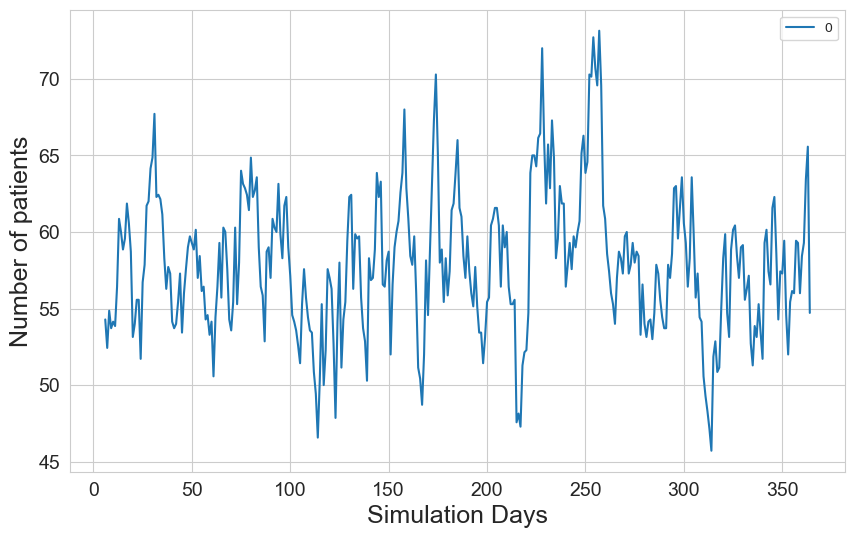

In [12]:
# Calculating the rolling 7 day average of patients seen
plot_linegraph(pd.DataFrame(metrics["num_patients_seen"]).rolling(7).mean(), "Simulation Days", "Number of patients")

In [18]:
# Over the year, the total number of patients seen
sum(metrics["num_patients_seen"])

21112

In [24]:
# Number of patients discharged, the difference between this number and the above are the patients given a follow-up
len(sim.discharged_patients)

20312

In [17]:
# The number of patients are generated at the start of the simulation and then extracted within the code via this command, so we can reconstruct the number of patients generated per day.
num_generated_patients = [len(sim.patient_generator.generate_new_patients(i)) for i in range(365)]

0 Reached
15 Reached
30 Reached
45 Reached
60 Reached
75 Reached
90 Reached
105 Reached
120 Reached
135 Reached
150 Reached
165 Reached
180 Reached
195 Reached
210 Reached
225 Reached
240 Reached
255 Reached
270 Reached
285 Reached
300 Reached
315 Reached
330 Reached
345 Reached
360 Reached


<Axes: >

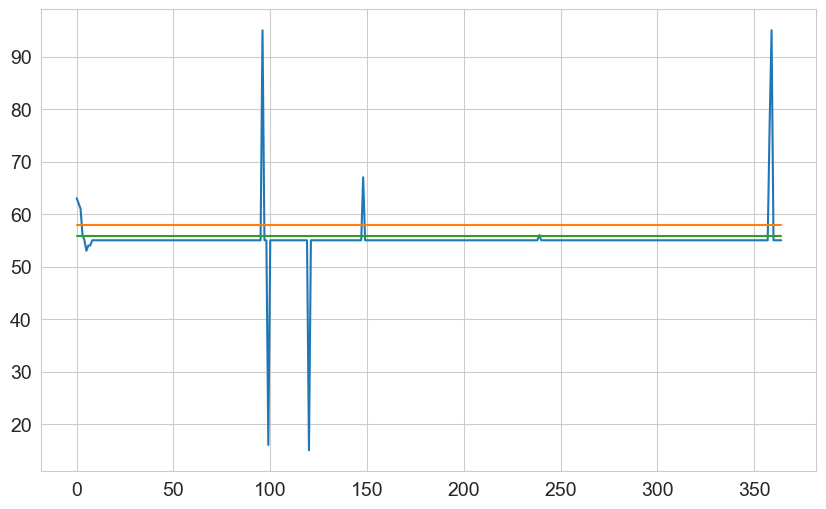

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [50]:
import numpy as np

# TODO: Check why this looks weird!
ax = plot_linegraph(num_generated_patients)

# plot_linegraph(metrics["num_patients_seen"], "Simulation Days", "Number of patients", ax=ax)
plot_linegraph([np.mean(metrics["num_patients_seen"])]*365, ax=ax)

plot_linegraph([(np.array(metrics["num_patients_seen"]) - np.array(metrics["num_dnas"]) - np.array(metrics["num_cancellations"]) + np.array(metrics["num_discharged"])).mean()]*365, ax=ax)

In [55]:
metrics[("num_patients_seen")]

[68,
 36,
 65,
 54,
 60,
 55,
 42,
 55,
 53,
 57,
 57,
 58,
 73,
 73,
 49,
 45,
 62,
 73,
 49,
 60,
 34,
 55,
 56,
 62,
 46,
 84,
 68,
 61,
 57,
 71,
 67,
 66,
 46,
 69,
 59,
 50,
 51,
 53,
 76,
 43,
 47,
 56,
 52,
 61,
 66,
 49,
 61,
 58,
 66,
 57,
 58,
 63,
 58,
 39,
 68,
 50,
 59,
 43,
 65,
 49,
 45,
 43,
 77,
 73,
 63,
 40,
 81,
 43,
 26,
 54,
 68,
 76,
 74,
 46,
 62,
 68,
 48,
 66,
 73,
 67,
 70,
 44,
 71,
 54,
 34,
 55,
 63,
 49,
 85,
 73,
 40,
 61,
 51,
 61,
 71,
 62,
 62,
 64,
 65,
 28,
 48,
 53,
 59,
 58,
 57,
 57,
 55,
 64,
 40,
 50,
 52,
 56,
 39,
 45,
 44,
 66,
 85,
 15,
 72,
 76,
 41,
 39,
 41,
 51,
 59,
 99,
 28,
 63,
 47,
 69,
 71,
 60,
 56,
 53,
 61,
 48,
 41,
 57,
 54,
 38,
 109,
 51,
 49,
 54,
 92,
 43,
 45,
 62,
 50,
 61,
 58,
 45,
 75,
 62,
 69,
 55,
 74,
 67,
 74,
 39,
 48,
 52,
 51,
 87,
 41,
 40,
 34,
 36,
 75,
 94,
 62,
 71,
 71,
 62,
 57,
 39,
 44,
 68,
 47,
 91,
 45,
 68,
 67,
 47,
 82,
 62,
 60,
 41,
 50,
 57,
 66,
 66,
 52,
 54,
 59,
 32,
 45,
 66,
 52,
 64,

<Axes: >

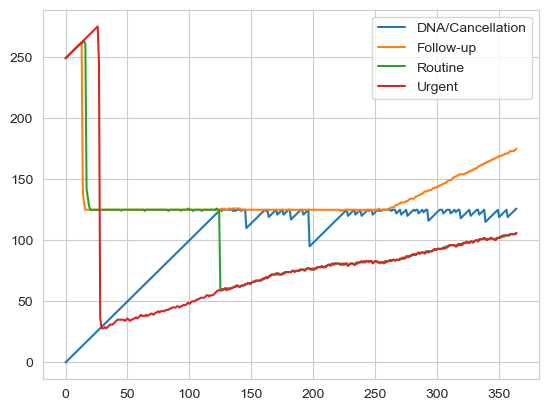

In [59]:
pd.DataFrame(metrics["max_wait_times_by_priority"]).plot()

In [23]:
int(sum(num_generated_patients) * 1.09)

21940

In [54]:
len(sim.discharged_patients)

20367

[3,
 2,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 3,
 0,
 4,
 1,
 0,
 1,
 1,
 3,
 1,
 1,
 0,
 3,
 1,
 2,
 0,
 0,
 0,
 1,
 0,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 0,
 1,
 2,
 0,
 1,
 1,
 1,
 2,
 1,
 1,
 0,
 2,
 1,
 0,
 0,
 2,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 0,
 1,
 2,
 0,
 2,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 2,
 0,
 1,
 0,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 2,
 0,
 0,
 1,
 0,
 2,
 2,
 0,
 2,
 3,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 3,
 1,
 2,
 1,
 0,
 1,
 0,
 0,
 2,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 2,
 0,
 1,
 1,
 1,
 0,
 3,
 2,
 0,
 1,
 0,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 2,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 3,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 2,
 0,
 0,
 2,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 2,
 1,
 0,
 1,
 2,
 0,
 1,
 1,
 2,
 1,
 2,
 0,
 2,
 1,
 2,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 2,
 1,
 4,
 2,
 0,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 2,
 0,
 3,
 1,
 1,
 1,
 3,
 0,
 3,
 0,
 0,
 0,
 2,
 1,
 2,
 3,
 1,
 0,
 2,
 2,
 0,


<Axes: >

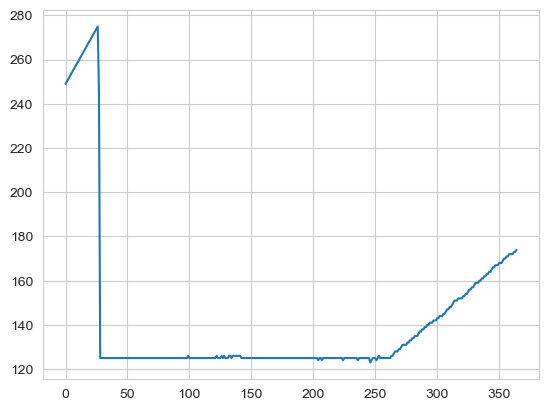

In [4]:
sns.lineplot(metrics["maximum_wait_time"])

<Axes: >

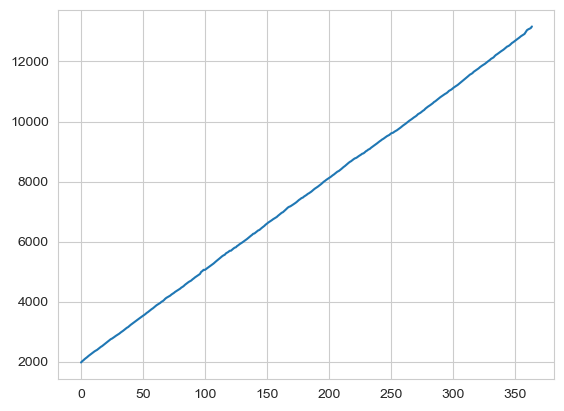

In [5]:
sns.lineplot(metrics["wait_list_length"])

<Axes: >

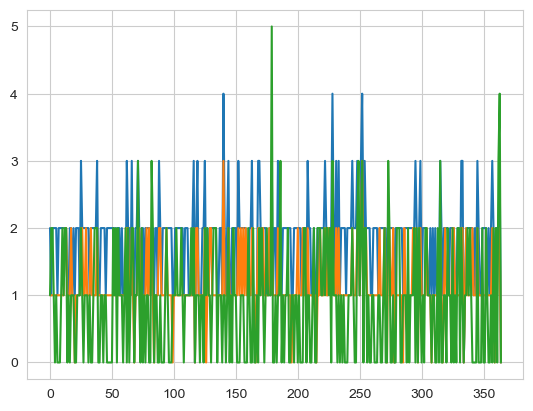

In [7]:
sns.lineplot(metrics["num_dnas"])
sns.lineplot(metrics["num_cancellations"])
sns.lineplot(metrics["num_discharged"])

<Axes: >

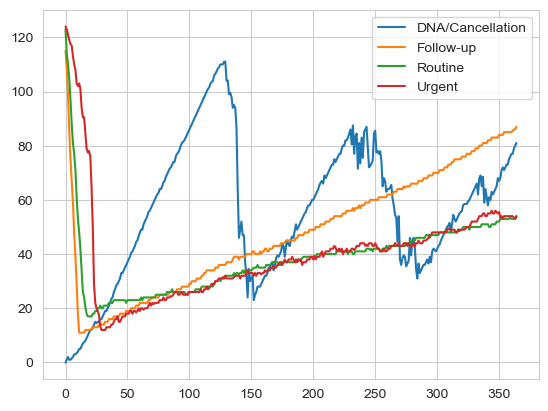

In [8]:
import pandas as pd

pd.DataFrame(metrics["median_wait_times_by_priority"]).plot()


In [ ]:
metrics.keys()

In [ ]:
# results = sim_wrapper.parallel_run(-1, 10)